# Average Hamiltonian Theory

_Will Kaufman, 2021_

Trying to calculate different orders of approximation for the average Hamiltonian of a given pulse sequence.

## TODO

- [ ] Establish timing for pulse sequences, use common timing
- [ ] Calculate full unitary of pulse sequence, then compare fidelities with that
- [ ] Try out longer pulse sequences, see if terms can be calculated quickly
- [ ] Think of other ways to evaluate/differentiate pulse sequences (geometric argument, others?)

In [1]:
import numpy as np
import qutip as qt
import sys
import os
from functools import lru_cache
import importlib

In [2]:
sys.path.append('..')

In [3]:
import pulse_sequences as ps

In [35]:
importlib.reload(ps)

<module 'pulse_sequences' from '../pulse_sequences.py'>

## Set up spin system

The system Hamiltonian is scaled using arbitrary units, where the time and energy scales are normalized to the chemical shift strength.

`Hsys` is a QuTiP Qobj, and `chemical_shifts` and `dipolar_matrix` are numpy arrays.

In [4]:
Hsys, chemical_shifts, dipolar_matrix = ps.get_Hsys(N=3, dipolar_strength=1e2, return_all=True)

In [6]:
X, Y, Z = ps.get_collective_spin(N=3)

In [7]:
interaction_frames = ps.get_pulses(Hsys, X, Y, Z, pulse_width=0, delay=0, rot_error=0)

Specify the pulse sequence below. The pulse sequences are arrays of integers, which specify a particular pulse. So far, the only pulses I've considered have been a "delay pulse" (no pulse applied, with the same time delay), a $\pi/2$-pulse along X, -X, Y, and -Y axes. These are indexed with integers 0 through 4 respectively.

In [56]:
sequence = ps.yxx48

In [82]:
Hsys.norm()

71.35297285680498

In [54]:
tau = [0.01] * len(sequence)  # spacing between pulses, scaled according to chemical shift strength
# NOTE: tau * ||Hsys|| << 1 should be satisfied for Magnus expansion to converge

## Calculate Magnus expansion terms

To speed up computation, the results of various toggling frames and commutators are stored in the list `H_list`. When a new commutator of terms is calculated, it's appended to the list and the index cached for future computations. The commutator function is defined further down.

In [57]:
frame = qt.identity(Hsys.dims[0])
H_list = []
for p in sequence:
    frame = interaction_frames[p] * frame
    H_list.append(frame.dag() * Hsys * frame)

In [59]:
def get_H0(H_list, tau, length):
    H0 = None
    for i, t in enumerate(tau):
        H0 = H_list[i] * t if H0 is None else H0 + H_list[i] * t
    return H0 / sum(tau)

In [60]:
H0 = get_H0(H_list, tau, len(sequence))

(<Figure size 432x288 with 2 Axes>,
 <mpl_toolkits.mplot3d.axes3d.Axes3D at 0x7fe385b52ed0>)

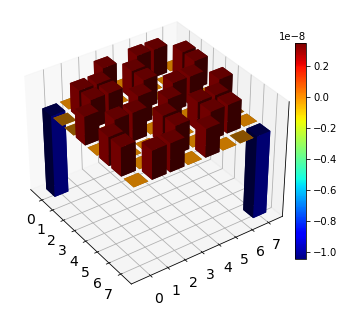

In [65]:
qt.visualization.matrix_histogram(H0)

In [52]:
# # For WHH-4, confirming that the H0 term is correct
# N = 3
# H0_AHT = sum([
#     qt.tensor(
#         [qt.identity(2)] * i
#         + [1/3
#            * chemical_shifts[i]
#            * (qt.sigmax()
#               + qt.sigmay()
#               + qt.sigmaz())]
#         + [qt.identity(2)] * (N - i - 1)
#     ) for i in range(N)
# ])

In [66]:
@lru_cache(None)
def comm(a, b):
    A = H_list[a]
    B = H_list[b]
    result = A*B - B*A
    H_list.append(result)
    return len(H_list) - 1

In [67]:
def get_H1(H_list, tau, length):
    """
    Args:
        H_list (list): List of Qobj representing toggled Hamiltonians or commutators
        tau (list): Time delays after each pulse
        length: Number of pulses in sequence
    """
    H1 = None
    for i in range(length):
        for j in range(i):
            index = comm(i, j)
            H1_new = H_list[index] * tau[i] * tau[j]
            H1 = H1_new if H1 is None else H1 + H1_new
    return 1/(2j * sum(tau)) * H1

In [68]:
H1 = get_H1(H_list, tau, len(sequence))

(<Figure size 432x288 with 2 Axes>,
 <mpl_toolkits.mplot3d.axes3d.Axes3D at 0x7fe38603c350>)

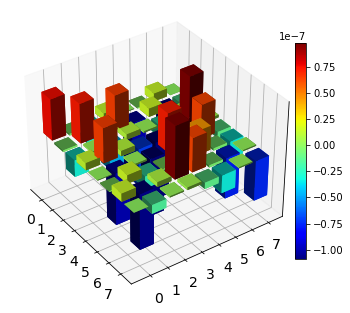

In [69]:
qt.visualization.matrix_histogram(H1)

In [70]:
def get_H2(H_list, tau, length):
    H2 = None
    for i in range(length):
        for j in range(i):
            for k in range(j):
                index1 = comm(i, comm(j, k))
                index2 = comm(comm(i, j), k)
                H2_new = (H_list[index1] + H_list[index2]) * tau[i] * tau[j] * tau[k]
                H2 = H2_new if H2 is None else H2 + H2_new
    return -1/(6 * sum(tau)) * H2

In [71]:
H2 = get_H2(H_list, tau, len(sequence))

(<Figure size 432x288 with 2 Axes>,
 <mpl_toolkits.mplot3d.axes3d.Axes3D at 0x7fe3723c6950>)

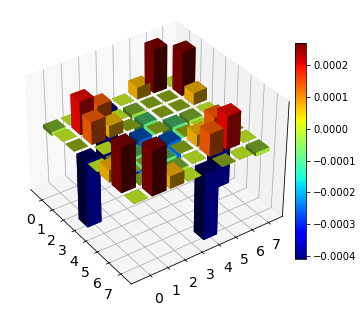

In [72]:
qt.visualization.matrix_histogram(H2)

In [25]:
def get_H3(H_list, tau, length):
    H3 = None
    for i in range(length):
        for j in range(i):
            for k in range(j):
                for l in range(k):
                    index1 = comm(comm(comm(i, j), k), l)
                    index2 = comm(i, comm(comm(j, k), l))
                    index3 = comm(i, comm(j, comm(k, l)))
                    index4 = comm(j, comm(k, comm(l, i)))
                    H3_new = (H_list[index1] + H_list[index2]
                              + H_list[index3] + H_list[index4]) * (
                        tau[i] * tau[j] * tau[k] * tau[l]
                    )
                    H3 = H3_new if H3 is None else H3 + H3_new
    return -1/(12j * sum(tau)) * H3

In [49]:
H3 = get_H3(H_list, tau, len(sequence))

In [ ]:
# def get_H4(H_list, tau, length):
#     H4 = None
#     for i in range(length):
#         for j in range(i):
#             for k in range(j):
#                 for l in range(k):
#                     for m in range(l):
#                         # TODO modify for 4th order term
#                         index1 = comm(comm(comm(i, j), k), l)
#                         index2 = comm(i, comm(comm(j, k), l))
#                         index3 = comm(i, comm(j, comm(k, l)))
#                         index4 = comm(j, comm(k, comm(l, i)))
#                         H3_new = (H_list[index1] + H_list[index2]
#                                   + H_list[index3] + H_list[index4]) * (
#                             tau[i] * tau[j] * tau[k] * tau[l]
#                         )
#                         H3 = H3_new if H3 is None else H3 + H3_new
#     throw NotImplementedError('This is not implemented yet!')
# #     return -1/(12j * sum(tau)) * H3

## Evaluate AHT approximations

Compare fidelity of different orders of Magnus expansion to the "actual" pulse sequence. For an apples-to-apples comparison, the pulses are considered to be delta-function pulses (no finite pulse width).

In [73]:
pulses = ps.get_pulses(Hsys, X, Y, Z, pulse_width=0, delay=tau[0])

In [74]:
U_sequence = qt.identity(pulses[0].dims[0])
for p in sequence:
    U_sequence = pulses[p] * U_sequence

In [80]:
U_H0 = qt.propagator(H0, sum(tau))
fidelity_0 = qt.metrics.average_gate_fidelity(U_sequence, U_H0)
-np.log10(1 - fidelity_0 + 1e-200)

4.9567457549349285

In [81]:
U_H1 = qt.propagator(H0 + H1, sum(tau))
fidelity_1 = qt.metrics.average_gate_fidelity(U_sequence, U_H1)
-np.log10(1 - fidelity_1 + 1e-200)

4.9567524544089645

In [79]:
U_H2 = qt.propagator(H0 + H1 + H2, sum(tau))
fidelity_2 = qt.metrics.average_gate_fidelity(U_sequence, U_H2)
-np.log10(1 - fidelity_2 + 1e-200)

4.957442972400607

In [91]:
fidelity_2 - fidelity_1

1.755064249486793e-08

By comparing the differences in values above, you can get a sense of how "important" each successive term is to the approximation. In the case of the yxx48 pulse sequence, the 0th-order approximation achieves an infidelity of $10^{-5}$, and the first and second orders only improve fidelity by $10^{-10}$ and $10^{-8}$ respectively.

(<Figure size 432x288 with 2 Axes>,
 <mpl_toolkits.mplot3d.axes3d.Axes3D at 0x7fe3729b3950>)

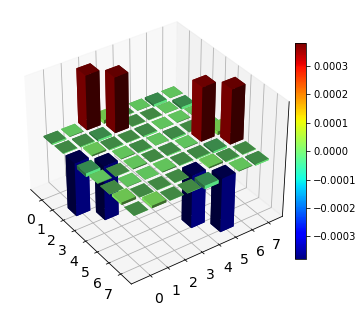

In [86]:
qt.visualization.matrix_histogram(U_sequence - qt.identity([2,2,2]))

## Check cyclic property

Pulse sequences should be cyclic (the frame transformation should be the identity after a full pulse sequence). My suspicion is that the main performance difference for pulse sequences is the degree to which they remain cyclic when rotation errors are included.

In [131]:
interaction_frames = ps.get_pulses(Hsys, X, Y, Z, pulse_width=0, delay=0, rot_error=0.01)

In [132]:
frame = qt.identity(Hsys.dims[0])
for p in sequence:
    frame = interaction_frames[p] * frame

In [133]:
(frame - qt.identity(frame.dims[0])).norm()

0.0002720877363496912

(<Figure size 432x288 with 2 Axes>,
 <mpl_toolkits.mplot3d.axes3d.Axes3D at 0x7fe37353aa10>)

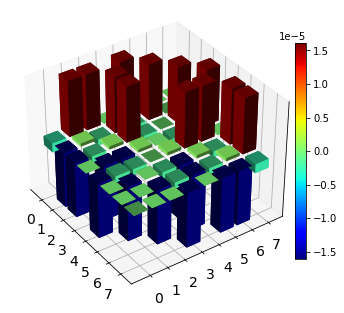

In [134]:
qt.visualization.matrix_histogram(frame - qt.identity(frame.dims[0]))